# Progressive Learning in a Simple Environment
## Gaussian XOR and Gaussian N-XOR Experiment

One key goal of progressive learning is to be able to continually improve upon past performance with the introduction of new data, without forgetting too much of the past tasks. This transfer of information can be evaluated using a variety of metrics; however, here, we use a generalization of Pearl's transfer-benefit ratio (TBR) in both the forward and backward directions.

As described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), the forward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:
$$FTE^t(f_n) := \mathbb{E}[R^t(f^{t}_n)/R^t(f^{<t}_n)].$$
If $FTE^t(f_n)>1$, the algorithm demonstrates positive forward transfer, i.e. past task data has been used to improve performance on the current task.

Similarly, the backward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:
$$BTE^t(f_n) := \mathbb{E}[R^t(f^{<t}_n)/R^t(f^{t}_n)].$$
If $BTE^t(f_n)>1$, the algorithm demonstrates positive backward transfer, i.e. data from the current task has been used to improve performance on past tasks.

Progressive learning in a simple environment can therefore be demonstrated using two simple tasks: Gaussian XOR and Gaussian Not-XOR (N-XOR). Here, forward transfer efficiency is the ratio of generalization errors for N-XOR, whereas backward transfer efficiency is the ratio of generalization errors for XOR.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns 

from sklearn.model_selection import StratifiedKFold
from math import log2, ceil 

import sys
from joblib import Parallel, delayed

from proglearn.forest import LifelongClassificationForest, UncertaintyForest

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Classification Problem

First, let's visualize Gaussian XOR and N-XOR.

Gaussian XOR is a two-class classification problem, where...
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.

Gaussian N-XOR has the same distribution as Gaussian XOR, but with the class labels flipped, i.e...
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.

We define a few functions to help in creating simulated XOR and N-XOR data:

In [2]:
# define functions for creating gaussian xor and n-xor data:

def generate_2d_rotation(theta=0, acorn=None):
    """
    Generates a rotation by angle theta.
    Returns:
    R - Array representing rotation by theta.
    """
    
    # if acorn is specified, set random seed to it
    if acorn is not None:
        np.random.seed(acorn)
    
    # create array to represent rotation of angle theta
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    return R

def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    """
    Generates Gaussian XOR problems and its variants (N-XOR, R-XOR). 
    Returns:
    X - Distributions of data points.
    Y - Class labels for the X distributions.
    """
    
    # if acorn is specified, set random seed to it
    if acorn is not None:
        np.random.seed(acorn)
    
    # create distributions
    d = len(mean)
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    Y = np.zeros(n)
    X = np.zeros((n, d))
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
    
    # rotate the resulting matrix by angle_params
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        R = generate_2d_rotation(angle_params)
        X = X @ R
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

Now that we've assembled the code to create the Gaussian XOR and N-XOR problems, let's generate the data and plot it to see what they look like!

In [3]:
# call function to return gaussian xor and n-xor data:
X, Y = generate_gaussian_parity(750, cov_scale=0.1, angle_params=0)
Z, W = generate_gaussian_parity(750, cov_scale=0.1, angle_params=np.pi/2)

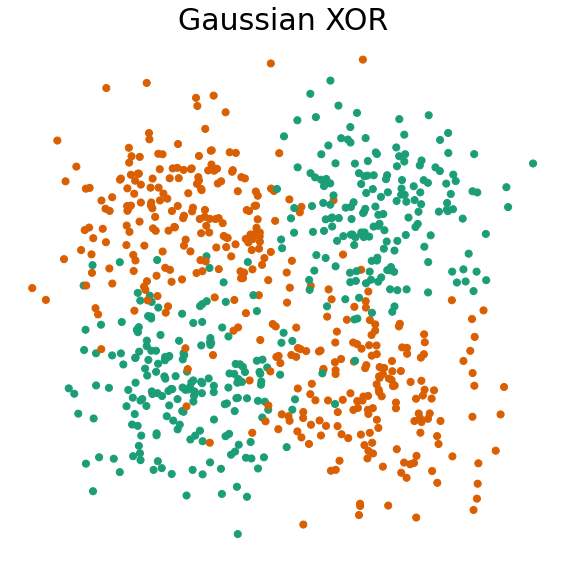

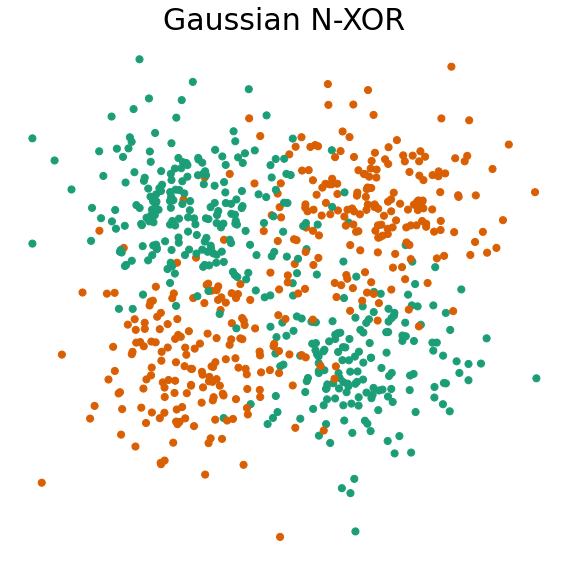

In [4]:
# plot and format plot:

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, Y), s=50)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)
plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=50)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian N-XOR', fontsize=30)
ax.axis('off')
plt.tight_layout()

### The Experiment

Since the functions for simulating the classification problem are now defined, the experiment can now be performed. We create another function to call the progressive learning algorithms, as follows:

In [5]:
def experiment(n_xor, n_nxor, n_test, reps, n_trees, max_depth, acorn=None):
    """
    Runs the Gaussian XOR N-XOR experiment.
    Returns the mean error.
    """
    
    # initialize experiment
    if n_xor==0 and n_nxor==0:
        raise ValueError('Wake up and provide samples to train!!!')
    
    # if acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)
    
    errors = np.zeros((reps,4),dtype=float)
    
    # run the progressive learning algorithm for a number of repetitions
    for i in range(reps):
        
        progressive_learner = LifelongClassificationForest(n_estimators=n_trees)
        uf = UncertaintyForest(n_estimators=2*n_trees)
        
        #source data
        xor, label_xor = generate_gaussian_parity(n_xor,cov_scale=0.1,angle_params=0)
        test_xor, test_label_xor = generate_gaussian_parity(n_test,cov_scale=0.1,angle_params=0)
    
        #target data
        nxor, label_nxor = generate_gaussian_parity(n_nxor,cov_scale=0.1,angle_params=np.pi/2)
        test_nxor, test_label_nxor = generate_gaussian_parity(n_test,cov_scale=0.1,angle_params=np.pi/2)
    
        if n_xor == 0:
            progressive_learner.add_task(nxor, label_nxor)
            l2f_task2=progressive_learner.predict(test_nxor, task_id=0)
            uf.fit(nxor, label_nxor)
            uf_task2=uf.predict(test_nxor)
            
            errors[i,0] = 0.5
            errors[i,1] = 0.5
            errors[i,2] = 1 - np.sum(uf_task2 == test_label_nxor)/n_test
            errors[i,3] = 1 - np.sum(l2f_task2 == test_label_nxor)/n_test
        elif n_nxor == 0:
            progressive_learner.add_task(xor, label_xor)
            l2f_task1=progressive_learner.predict(test_xor, task_id=0)
            uf.fit(xor, label_xor)
            uf_task1=uf.predict(test_xor)
            
            errors[i,0] = 1 - np.sum(uf_task1 == test_label_xor)/n_test
            errors[i,1] = 1 - np.sum(l2f_task1 == test_label_xor)/n_test
            errors[i,2] = 0.5
            errors[i,3] = 0.5
        else:
            progressive_learner.add_task(xor, label_xor)
            progressive_learner.add_task(nxor, label_nxor)
            l2f_task1=progressive_learner.predict(test_xor, task_id=0)
            l2f_task2=progressive_learner.predict(test_nxor, task_id=1)
            
            uf.fit(xor, label_xor)
            uf_task1=uf.predict(test_xor)
            uf.fit(nxor, label_nxor)
            uf_task2=uf.predict(test_nxor)
            
            errors[i,0] = 1 - np.sum(uf_task1 == test_label_xor)/n_test
            errors[i,1] = 1 - np.sum(l2f_task1 == test_label_xor)/n_test
            errors[i,2] = 1 - np.sum(uf_task2 == test_label_nxor)/n_test
            errors[i,3] = 1 - np.sum(l2f_task2 == test_label_nxor)/n_test

    return np.mean(errors,axis=0)

Now, we can select the primary parameters with which we'd like to run the experiment using.

In [6]:
# define primary parameters:
mc_rep = 500
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

Once those are determined, the experiment can be initialized and performed

In [7]:
# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((4, len(n_xor)+len(n_nxor)))
std_error = np.zeros((4, len(n_xor)+len(n_nxor)))
mean_te = np.zeros((2, len(n_xor)+len(n_nxor)))
std_te = np.zeros((2, len(n_xor)+len(n_nxor)))

# initialize learning on xor data
for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    # run experiment in parallel
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(n1,0,n_test,1,n_trees=n_trees,max_depth=ceil(log2(750))) for _ in range(mc_rep)
    )
    )
    # extract relevant data and store in arrays
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0]/error[:,1])
    mean_te[1,i] = np.mean(error[:,2]/error[:,3])
    std_te[0,i] = np.std(error[:,0]/error[:,1],ddof=1)
    std_te[1,i] = np.std(error[:,2]/error[:,3],ddof=1)
    
    # initialize learning on n-xor data
    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_nxor):
            print('starting to compute %s nxor\n'%n2)
            # run experiment in parallel
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(n1,n2,n_test,1,n_trees=n_trees,max_depth=ceil(log2(750))) for _ in range(mc_rep)
            )
            )
            # extract relevant data and store in arrays
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0]/error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2]/error[:,3])
            std_te[0,i+j+1] = np.std(error[:,0]/error[:,1],ddof=1)
            std_te[1,i+j+1] = np.std(error[:,2]/error[:,3],ddof=1)

starting to compute 50 xor



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 75 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 100 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 125 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 150 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 175 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 200 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 225 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 250 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 275 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 300 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 325 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 350 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 375 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 400 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 425 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 450 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 475 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 500 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 525 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 550 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 575 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 600 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 625 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 650 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 675 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 700 xor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 50 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 75 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 100 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 125 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 150 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 175 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 200 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 225 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 250 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 275 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 300 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.9min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 325 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 350 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 375 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 400 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 425 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 450 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 475 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 500 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 525 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 550 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 575 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 600 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 625 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 650 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 675 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 700 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


starting to compute 725 nxor



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished


Great! The experiment should now be complete, with the results stored in four arrays: `mean_error`, `std_error`, `mean_te`, and `std_te`.

### Visualizing the Results

Now that the experiment is complete, the results can be visualized by extracting the data from these arrays and plotting it. 

#### Generalization Error for XOR Data

By plotting the generalization error for XOR data, we can see how the introduction of N-XOR data influenced the performance of both the uncertainty forest and lifelong forest algorithms. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


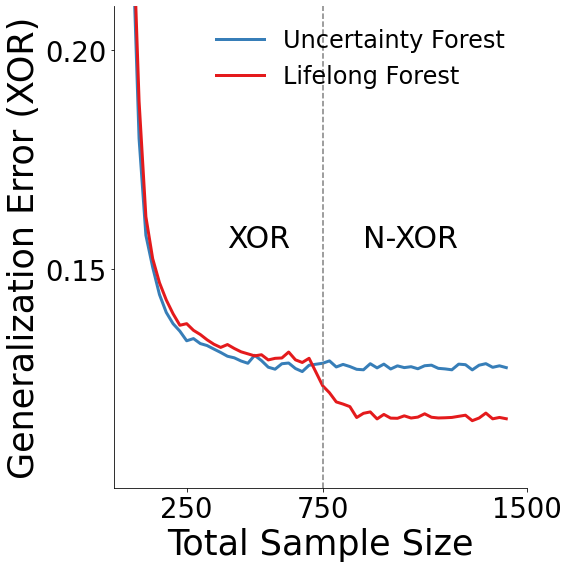

In [8]:
# define scale and labels
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)
n1s = n_xor
n2s = n_nxor
ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['Uncertainty Forest', 'Lifelong Forest']
TASK1='XOR'
TASK2='N-XOR'

# plot and format figure
fontsize=35
labelsize=27.5
colors = sns.color_palette("Set1", n_colors = 2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[1], label=algorithms[1], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontname="Arial", fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=24, frameon=False)
ax1.set_ylim(0.1, 0.21)
ax1.set_xlabel('Total Sample Size', fontname="Arial", fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.15, 0.2])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

When N-XOR data is available, lifelong forest outperforms uncertainty forest.

#### Generalization Error for N-XOR Data

Similarly, by plotting the generalization error for N-XOR data, we can also see how the presence of XOR data influenced the performance of both algorithms. 

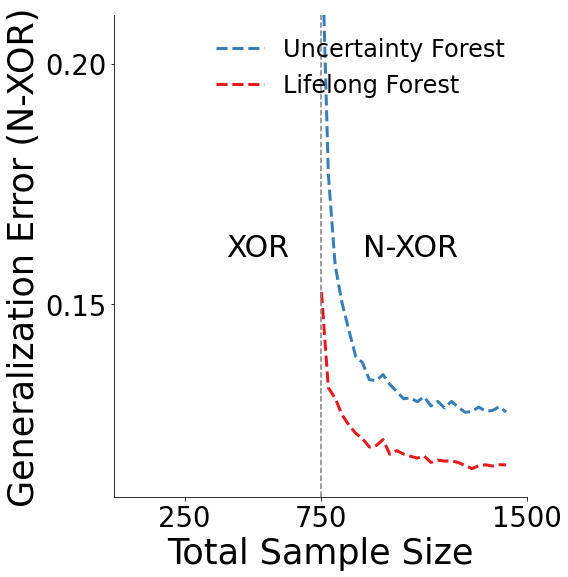

In [9]:
# define labels
algorithms = ['Uncertainty Forest', 'Lifelong Forest']
TASK1='XOR'
TASK2='N-XOR'

# plot and format figure
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[0], c=colors[1], ls=ls[1], lw=3)
ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=24, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.15, 0.2])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_ylim(0.11, 0.21)
ax1.set_xlim(-10)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

Given XOR data, lifelong forest outperforms uncertainty forests on classifying N-XOR data.

#### Transfer Efficiency for XOR Data

Given the generalization errors plotted above, we can find the transfer efficiency as a ratio of the generalization error for lifelong forest to uncertainty forest. The forward and backward transfer efficiencies can then be plotted as follows:

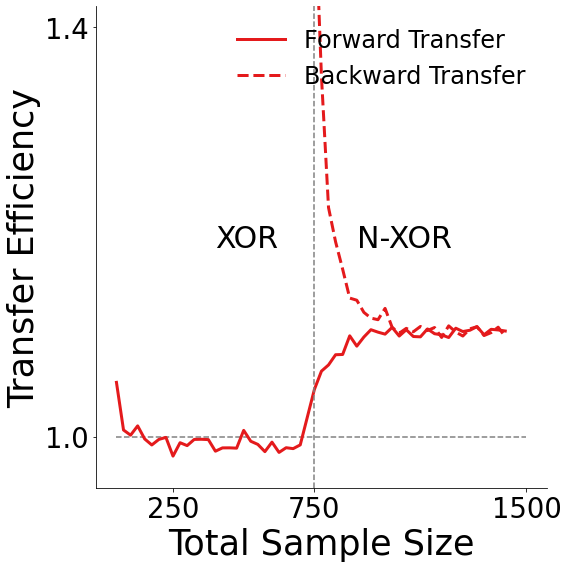

In [10]:
# define labels
algorithms = ['Forward Transfer', 'Backward Transfer']
TASK1='XOR'
TASK2='N-XOR'

# plot and format figure
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=24, frameon=False)
ax1.set_ylim(0.95, 1.42)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([1, 1.4])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)
ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

Lifelong forests demonstrate both positive forward and backward transfer in this environment.